## Treat the genres of the movies##

Attribute a new number to each new genre and replace in the dataframe

In [68]:
%matplotlib inline

import configparser
import os

import requests
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import sparse, stats, spatial
import scipy.sparse.linalg
from sklearn import preprocessing, decomposition
import librosa
import IPython.display as ipd
import json
from imdb import IMDb
import tmdbsimple as tmdb
from pygsp import graphs, filters, plotting

plt.rcParams['figure.figsize'] = (17, 5)
plotting.BACKEND = 'matplotlib'

In [69]:
df = pd.read_csv('Saved_Datasets/NewFeaturesDataset.csv')

In [70]:
print('There are {} movies'.format(len(df)))

There are 2621 movies


In [71]:
df['genres'][1]

'Drama|Crime|Music'

In [72]:
df.head()
#df.iloc[100:150]

,id,budget,genres,imdb_id,overview,production_companies,release_date,revenue,title,director_name,actor_names,Metacritic,ROI,success
0,12,94000000,Animation|Family,266543,"Nemo, an adventurous young clownfish, is unexp...",Pixar Animation Studios,2003-05-30,940335536,Finding Nemo,Andrew Stanton,"['Albert Brooks', 'Ellen DeGeneres', 'Alexande...",90,2.639,4
1,16,12800000,Drama|Crime|Music,168629,"Selma, a Czech immigrant on the verge of blind...",Fine Line Features,2000-05-17,40031879,Dancer in the Dark,Lars von Trier,"['Björk', 'Catherine Deneuve', 'David Morse', ...",61,2.127,3
2,22,140000000,Adventure|Fantasy|Action,325980,"Jack Sparrow, a freewheeling 17th-century pira...",Walt Disney Pictures,2003-09-07,655011224,Pirates of the Caribbean: The Curse of the Bla...,Gore Verbinski,"['Johnny Depp', 'Geoffrey Rush', 'Orlando Bloo...",63,2.639,4
3,24,30000000,Action|Crime,266697,An assassin is shot at the altar by her ruthle...,Miramax Films,2003-10-10,180949000,Kill Bill: Vol. 1,Quentin Tarantino,"['Uma Thurman', 'Lucy Liu', 'Vivica A. Fox', '...",69,2.639,4
4,25,72000000,Drama|War,418763,Jarhead is a film about a US Marine Anthony Sw...,Universal Pictures,2005-04-11,96889998,Jarhead,Sam Mendes,"['Jamie Foxx', 'Scott MacDonald', 'Lucas Black...",58,0.346,2


### 1. Parsing example ###

In [73]:
df['genres'] = df['genres'].str.replace('|', ',') 

In [74]:
i = 1
newgenres = df['genres'][i].split(",")

print(newgenres)
print(len(newgenres))

['Drama', 'Crime', 'Music']
3


### 2. Determine different genres ###

Determine the number of different genres and what they are.

In [75]:
Diffgenres = [];
genres = {}
movies_dic = {}

for i in range(0, len(df)):
    
    movies_dic[i] = df['id'][i]
    
    if df['genres'][i] == 'NaN':
        newgenres = []
    else:
        newgenres = df['genres'][i].split(",")
        
        genres.setdefault(i, [])
        
        for j in range (0, len(newgenres)):
            Diffgenres.append(newgenres[j])
            genres[i].append(newgenres[j])

In [76]:
Diffgenres = set(Diffgenres)
Diffgenres = list(Diffgenres)

print('There are {} different genres'.format(len(Diffgenres)))
print(Diffgenres)

There are 20 different genres
['TV Movie', 'War', 'Music', 'Drama', 'Thriller', 'Western', 'Comedy', 'Foreign', 'Crime', 'Mystery', 'Horror', 'History', 'Adventure', 'Animation', 'Action', 'Romance', 'Fantasy', 'Science Fiction', 'Family', 'Documentary']


In [77]:
df.head()

,id,budget,genres,imdb_id,overview,production_companies,release_date,revenue,title,director_name,actor_names,Metacritic,ROI,success
0,12,94000000,"Animation,Family",266543,"Nemo, an adventurous young clownfish, is unexp...",Pixar Animation Studios,2003-05-30,940335536,Finding Nemo,Andrew Stanton,"['Albert Brooks', 'Ellen DeGeneres', 'Alexande...",90,2.639,4
1,16,12800000,"Drama,Crime,Music",168629,"Selma, a Czech immigrant on the verge of blind...",Fine Line Features,2000-05-17,40031879,Dancer in the Dark,Lars von Trier,"['Björk', 'Catherine Deneuve', 'David Morse', ...",61,2.127,3
2,22,140000000,"Adventure,Fantasy,Action",325980,"Jack Sparrow, a freewheeling 17th-century pira...",Walt Disney Pictures,2003-09-07,655011224,Pirates of the Caribbean: The Curse of the Bla...,Gore Verbinski,"['Johnny Depp', 'Geoffrey Rush', 'Orlando Bloo...",63,2.639,4
3,24,30000000,"Action,Crime",266697,An assassin is shot at the altar by her ruthle...,Miramax Films,2003-10-10,180949000,Kill Bill: Vol. 1,Quentin Tarantino,"['Uma Thurman', 'Lucy Liu', 'Vivica A. Fox', '...",69,2.639,4
4,25,72000000,"Drama,War",418763,Jarhead is a film about a US Marine Anthony Sw...,Universal Pictures,2005-04-11,96889998,Jarhead,Sam Mendes,"['Jamie Foxx', 'Scott MacDonald', 'Lucas Black...",58,0.346,2


### 3. Create vector of genres for each movie and a dataframe ###

Binary vector where the elements are 1 if the film has the genre corresponding to the index of the film. Otherwise the elements are zero.

Quick example:

In [78]:
print(genres[0][0])
len(genres[0][0])

vector = (genres[0][0] == np.array(Diffgenres)).astype(int)
print(vector)

Animation
[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]


In [79]:
genreArray = np.ndarray(shape=(len(df), len(Diffgenres)), dtype=int)

for i in range(0, len(df)):
    vector = np.zeros(len(Diffgenres))
    
    for j in range(0, len(genres[i])):
        vector += (genres[i][j] == np.array(Diffgenres)).astype(int)
    
    genreArray[i] = vector

In [80]:
print(genreArray[0])
print(genreArray.size)

[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0]
52420


Observe the result in the dataframe

In [81]:
Genres = pd.DataFrame(genreArray, columns=Diffgenres)
Genres.head(10)

,TV Movie,War,Music,Drama,Thriller,Western,Comedy,Foreign,Crime,Mystery,Horror,History,Adventure,Animation,Action,Romance,Fantasy,Science Fiction,Family,Documentary
0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0
3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
4,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
6,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0
7,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0
9,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


#### VIsual example of the genres ####

In [82]:
#Genres.iloc[120:150]

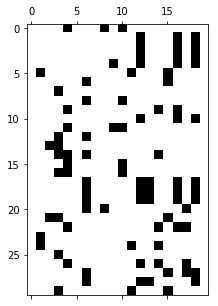

In [83]:
plt.spy(Genres[120:150])

#### 3.1 Determine most frequent genres ####

In [84]:
freqGenre = np.ndarray(shape=(1, len(Diffgenres)), dtype=int)

for i in range(0, len(Diffgenres)):
    freqGenre[0][i] = sum(Genres[Diffgenres[i]] == 1)

Display of the number of times a genre appears in the dataframe

In [85]:
NbGenre = pd.DataFrame(freqGenre, columns=Diffgenres)
NbGenre

,TV Movie,War,Music,Drama,Thriller,Western,Comedy,Foreign,Crime,Mystery,Horror,History,Adventure,Animation,Action,Romance,Fantasy,Science Fiction,Family,Documentary
0,1,74,81,1212,785,26,910,6,419,230,278,88,491,160,684,457,261,297,293,36


In [86]:
NbGenre.to_csv('Saved_Datasets/NbGenre.csv', index=False)

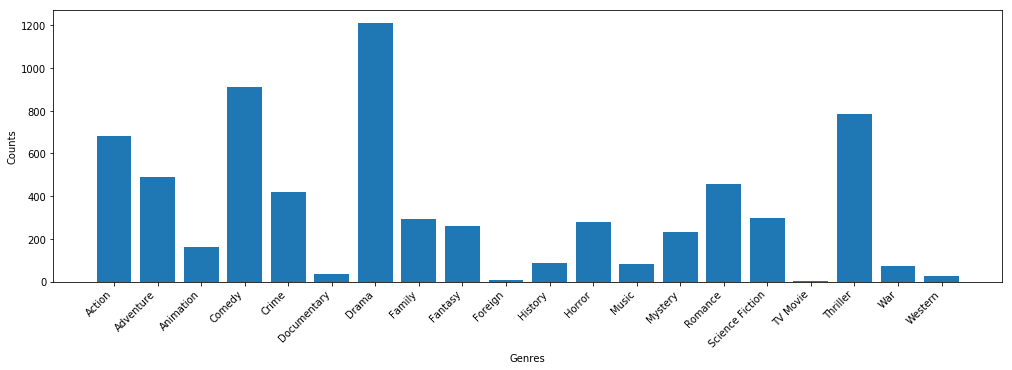

In [87]:
plt.bar(Diffgenres, freqGenre[0], align='center');
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right');
plt.xlabel('Genres');
plt.ylabel('Counts');
plt.savefig('images/GenreFreq.png', dpi =300, bbox_inches='tight')

#### 3.2 Determine genres that are most commonly associated with each other ####

We only consider two genres together at the moment

In [88]:
assosGenre = np.ndarray(shape=(len(Diffgenres), len(Diffgenres)), dtype=int)

for i in range(0, len(Diffgenres)):
    for j in range(0, len(Diffgenres)):
        if i != j:
            assosGenre[i][j] = sum((Genres[Diffgenres[i]] == 1) & (Genres[Diffgenres[j]] == 1))
        else:
            assosGenre[i][j] = 0

In [89]:
#ensure the matrix is symmetric
assosGenreSym = assosGenre.transpose() > assosGenre
assosGenre = assosGenre - assosGenre*assosGenreSym + assosGenre.transpose()*assosGenreSym

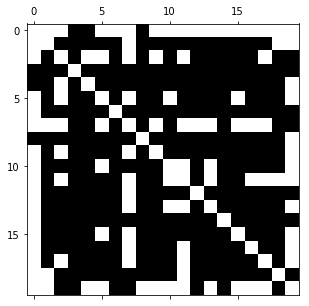

In [90]:
plt.spy(assosGenre)

In [91]:
NbGenreAssos = pd.DataFrame(assosGenre, columns=Diffgenres, index = Diffgenres)
NbGenreAssos

,TV Movie,War,Music,Drama,Thriller,Western,Comedy,Foreign,Crime,Mystery,Horror,History,Adventure,Animation,Action,Romance,Fantasy,Science Fiction,Family,Documentary
TV Movie,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
War,0,0,1,56,18,1,4,0,2,1,1,26,14,1,31,10,2,2,0,0
Music,0,1,0,48,0,0,36,0,3,0,1,0,3,7,3,33,7,0,14,6
Drama,1,56,48,0,355,13,274,3,230,121,53,81,108,5,177,307,56,58,36,2
Thriller,1,18,0,355,0,7,50,1,268,161,174,18,114,4,330,34,40,134,4,0
Western,0,1,0,13,7,0,4,0,5,2,0,1,12,2,11,0,2,1,2,0
Comedy,0,4,36,274,50,4,0,1,92,18,22,3,142,96,143,262,80,42,181,5
Foreign,0,0,0,3,1,0,1,0,2,0,1,0,0,0,1,0,0,0,1,2
Crime,1,2,3,230,268,5,92,2,0,74,21,7,32,1,181,20,6,9,2,0
Mystery,0,1,0,121,161,2,18,0,74,0,61,2,25,1,44,21,13,29,3,0


In [92]:
NbGenreAssos.to_csv('Saved_Datasets/NbGenreAssos.csv', index=False)

#### Determining ranking of genre associations ####

1 indicates most frequently associated and 19 is least frequently associated. 

$\textbf{Reminder:}$ This is only the case of our dataset and may not represent reality

In [93]:
assosRank = {} 
rank = np.argsort(-assosGenre, axis=1) #negative for ascending order

Diffgenres[rank[0][1]]

for i in range(0, len(Diffgenres)):
    for j in range(0, len(Diffgenres)):
        assosRank.setdefault(Diffgenres[i], [])
        
        #Only if not comparing with the same genre
        if Diffgenres[i] != Diffgenres[rank[i][j]]:
            assosRank[Diffgenres[i]].append(Diffgenres[rank[i][j]])

Display of the ranking of the other genres with which each genre is most often associated

In [94]:
ranking = np.linspace(1, len(Diffgenres)-1, num=len(Diffgenres)-1, endpoint=True, retstep=False, dtype=int)

Rankdf = pd.DataFrame(assosRank, index=ranking)
Rankdf

,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
1,Thriller,Action,Family,Drama,Thriller,Music,Thriller,Comedy,Adventure,Drama,Drama,Thriller,Drama,Thriller,Drama,Action,Drama,Drama,Drama,Drama
2,Adventure,Family,Comedy,Romance,Drama,Comedy,Romance,Adventure,Action,Documentary,War,Mystery,Comedy,Drama,Comedy,Adventure,Thriller,Action,Action,Adventure
3,Crime,Comedy,Adventure,Family,Action,Family,Comedy,Animation,Family,Crime,Action,Drama,Romance,Crime,Fantasy,Thriller,Crime,Crime,History,Action
4,Drama,Fantasy,Fantasy,Action,Comedy,Drama,Crime,Fantasy,Comedy,Thriller,Thriller,Action,Family,Horror,Thriller,Drama,Science Fiction,Horror,Thriller,Thriller
5,Science Fiction,Science Fiction,Action,Adventure,Mystery,Foreign,Action,Action,Drama,Comedy,Adventure,Science Fiction,Fantasy,Action,Adventure,Fantasy,Fantasy,Mystery,Adventure,Crime
6,Comedy,Thriller,Science Fiction,Animation,Adventure,Action,Mystery,Drama,Science Fiction,Action,Romance,Fantasy,Animation,Science Fiction,Music,Comedy,Romance,Science Fiction,Romance,Comedy
7,Fantasy,Drama,Music,Crime,Horror,Adventure,Adventure,Science Fiction,Thriller,Family,Crime,Comedy,Documentary,Adventure,Family,Horror,Action,Adventure,Comedy,Mystery
8,Horror,Animation,Drama,Fantasy,Romance,TV Movie,History,Romance,Romance,Horror,Comedy,Crime,Action,Romance,Action,Family,Animation,Comedy,Science Fiction,Fantasy
9,Mystery,Romance,Thriller,Thriller,Science Fiction,Science Fiction,Science Fiction,Music,Animation,Science Fiction,Mystery,Adventure,Crime,Comedy,Mystery,Mystery,Adventure,Fantasy,Fantasy,Family
10,Family,Crime,Romance,Science Fiction,History,Fantasy,War,Thriller,Horror,Fantasy,Western,Romance,Adventure,Fantasy,Crime,Animation,History,Romance,Crime,Animation


In [95]:
Rankdf.to_csv('Saved_Datasets/GenreRanking.csv', index=False)

#### 3.3 Determine how many films are successful or are non-successful depending on the genre ####

In [96]:
genreArray[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0])

In [97]:
genreSuccess = np.zeros(shape=(1, len(Diffgenres)), dtype=float)
genreSuccessPc = np.zeros(shape=(1, len(Diffgenres)), dtype=float)

for i in range(0, len(Diffgenres)):
    for j in range(0, len(df)):
        if genreArray[j][i] == 1:
            if df['success'][j] == 1:
                genreSuccess[0][i] += 1
    
    genreSuccessPc[0][i] = (genreSuccess[0][i]/freqGenre[0][i])*100

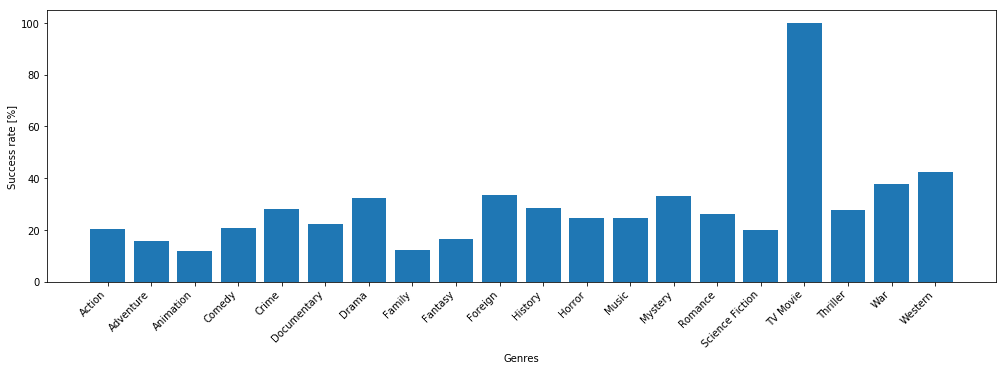

In [98]:
plt.bar(Diffgenres, genreSuccessPc[0], align='center');
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right');
plt.xlabel('Genres');
plt.ylabel('Success rate [%]');

Don't forget that the number of successful movies is not equal to the sum of the success rate of the genres since movies often have multiple genres.

In [99]:
print(sum(sum(genreSuccess)))
print('The number of films that are succesful: {}'.format(len(df[df['success'] == 1])))
print('The number of films that are unsuccesful: {}'.format(len(df[df['success'] == 0])))

1651.0
The number of films that are succesful: 655
The number of films that are unsuccesful: 0


### 4. Create a similarity  graph between films depending on genre ###

In this case, the similarity is the number of genres that the movie has in common:

$\mathbf{W}(u,v) = sum(u \cdot v) \ \in [0, 20]$

In [100]:
weights = np.ndarray(shape=(len(df), len(df)), dtype=int)

weights = genreArray @ genreArray.T

#fill the diagonal values to zero, i.e. no self-connections
np.fill_diagonal(weights, 0)

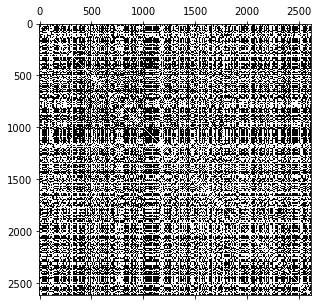

In [101]:
plt.spy(weights)

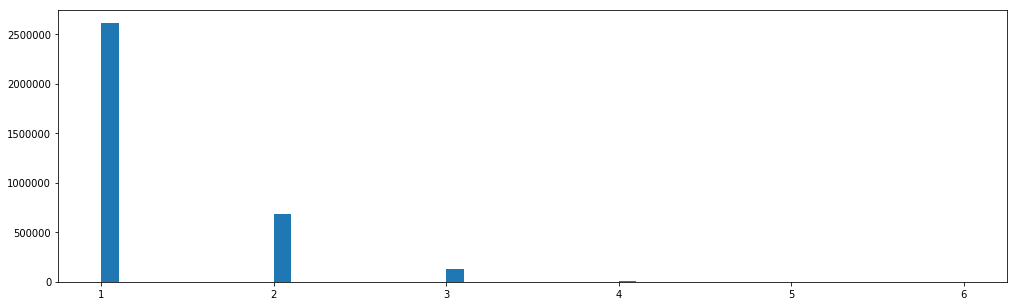

In [102]:
plt.hist(weights[weights > 0].reshape(-1), bins=50);

In [103]:
print('There are {} weights equal to zero'.format(np.sum(weights == 0)))
print('There are {} weights equal to one'.format(np.sum(weights == 1)))
print('There are {} weights equal to seven'.format(np.sum(weights == 7)))

There are 3430935 weights equal to zero
There are 2611932 weights equal to one
There are 0 weights equal to seven


In [104]:
meanW = weights.mean()
maxW = weights.max()
minW = weights.min()

print('The mean value of the similarity in terms of genre is: {}'.format(meanW))
print('The max value of the similarity is: {}'.format(maxW))
print('The min value of the similarity is: {}'.format(minW))

The mean value of the similarity in terms of genre is: 0.6433494850749842
The max value of the similarity is: 6
The min value of the similarity is: 0


#### 4.1 Normalization of the matrix ####

In [105]:
print(genreArray[1])
print(sum(genreArray[1]))

[0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
3


In [106]:
weightsNorm = np.ndarray(shape=(len(df), len(df)), dtype=float)
lengths =  np.ndarray(shape=(1, 2), dtype=int)
lenMax = 0;

for i in range(0, len(weights)):
    for j in range(0, len(weights)):
        if i!=j: 
            lengths = [sum(genreArray[i]), sum(genreArray[j])]
            weightsNorm[i][j] = (weights[i][j])/max(lengths) 

np.fill_diagonal(weightsNorm, 0)

In [107]:
sigma = np.std(weights)
print(sigma)
mu = np.mean(weights)
print(mu)
#1/(sigma*math.sqrt(2*math.pi))*
Wgauss = np.exp(-((weights-mu)**2)/(2*sigma**2))

#fill the diagonal values to zero, i.e. no self-connections
np.fill_diagonal(Wgauss, 0)

0.750927221103
0.643349485075


Maximum normalization 

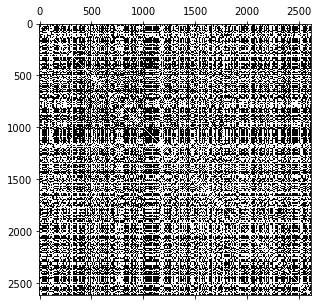

In [108]:
plt.spy(weightsNorm)

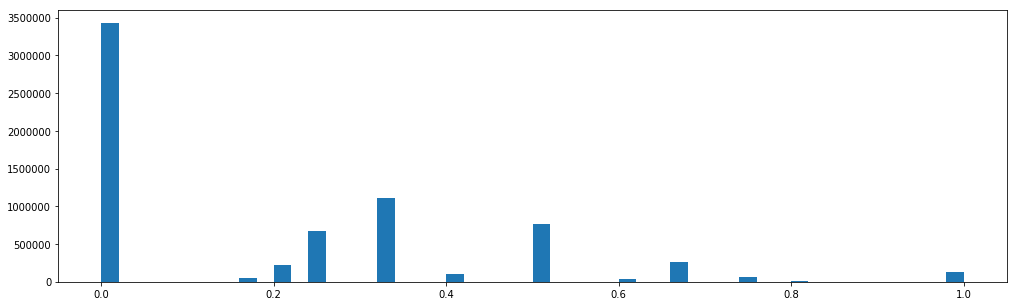

In [109]:
plt.hist(weightsNorm.reshape(-1), bins=50);

In [110]:
print('The mean value is: {}'.format(weightsNorm.mean()))
print('The max value is: {}'.format(weightsNorm.max()))
print('The min value is: {}'.format(weightsNorm.min()))

The mean value is: 0.20359825069114826
The max value is: 1.0
The min value is: 0.0


Plot the degree distribution

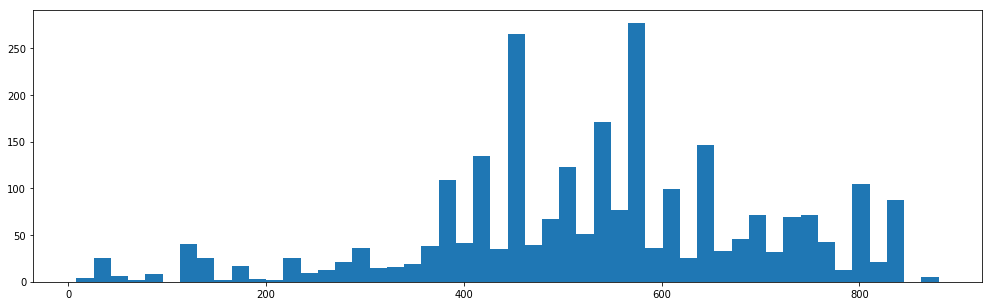

In [111]:
degrees = np.zeros(len(weightsNorm)) 

#reminder: the degrees of a node for a weighted graph are the sum of its weights

for i in range(0, len(weightsNorm)):
    degrees[i] = sum(weightsNorm[i])

plt.hist(degrees, bins=50);

In [112]:
print('The mean value is: {}'.format(degrees.mean()))
print('The max value is: {}'.format(degrees.max()))
print('The min value is: {}'.format(degrees.min()))

The mean value is: 533.6310150614994
The max value is: 880.2142857142858
The min value is: 7.999999999999999


Gaussian normalization

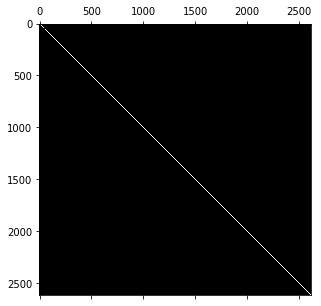

In [113]:
plt.spy(Wgauss)

#### 4.3 Save the dataset ####

In [114]:
NormW = pd.DataFrame(weightsNorm)
NormW.head()

,0,1,2,3,4,5,6,7,8,9,...,2611,2612,2613,2614,2615,2616,2617,2618,2619,2620
0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.666667,0.000000,0.000000,0.000000,...,0.0,0.00,0.000000,0.000000,0.000000,0.333333,0.000000,0.0,0.4,0.000000
1,0.0,0.000000,0.000000,0.333333,0.333333,0.666667,0.000000,0.333333,0.000000,0.666667,...,0.0,0.50,0.333333,0.333333,0.333333,0.333333,0.333333,0.0,0.0,0.333333
2,0.0,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.0,0.25,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.6,0.000000
3,0.0,0.333333,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.333333,...,0.0,0.50,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.2,0.000000
4,0.0,0.333333,0.000000,0.000000,0.000000,0.333333,0.000000,0.333333,0.000000,0.333333,...,0.0,0.25,0.333333,0.500000,0.500000,0.333333,0.500000,0.0,0.0,0.500000


In [115]:
NormW.to_csv('Saved_Datasets/NormalizedGenreW.csv', index=False)

### 5. Graph Laplacian and Embedding for maximum normalization ###

#### 5.1 Compute the graph Laplacian ####

With pygsp

In [116]:
G = graphs.Graph(weightsNorm)
G.compute_laplacian('normalized')

Normally

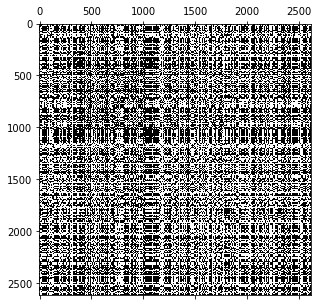

In [117]:
#reminder: L = D - W for weighted graphs
laplacian = np.diag(degrees) - weightsNorm

#computation of the normalized Laplacian
laplacian_norm = scipy.sparse.csgraph.laplacian(weightsNorm, normed = True)

plt.spy(laplacian_norm);

In [118]:
laplacian_norm = sparse.csr_matrix(laplacian_norm)

#### 5.2 Compute the Fourier basis ####

With pygsp

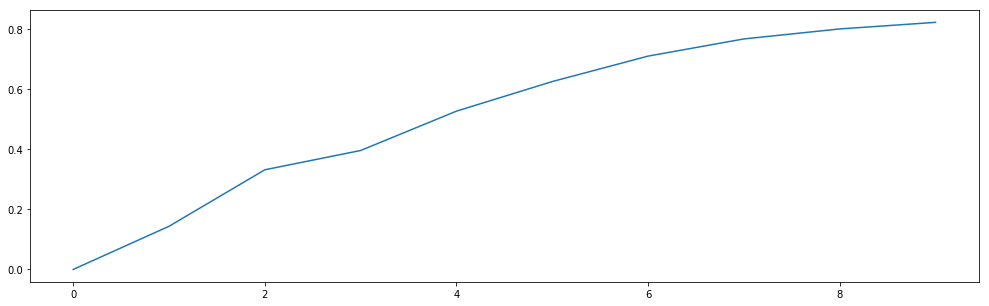

In [119]:
G.compute_fourier_basis(recompute=True)
plt.plot(G.e[0:10]);

Normally

In [120]:
eigenvalues, eigenvectors =  sparse.linalg.eigsh(laplacian_norm, k = 10, which = 'SM') 

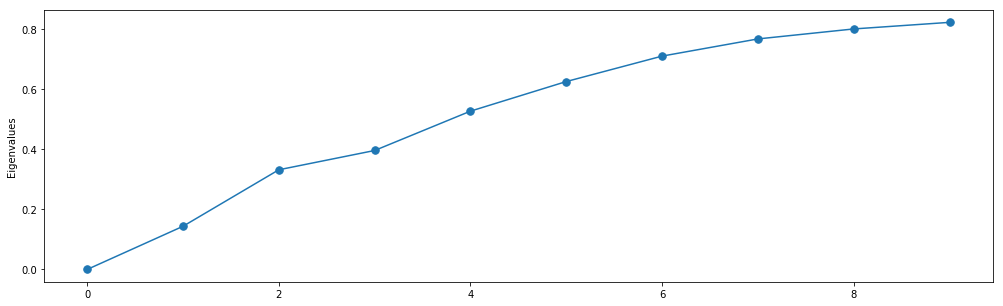

In [121]:
plt.plot(eigenvalues, '.-', markersize=15);
plt.xlabel('')
plt.ylabel('Eigenvalues')
plt.show()

#### 5.3 Graph embedding ####

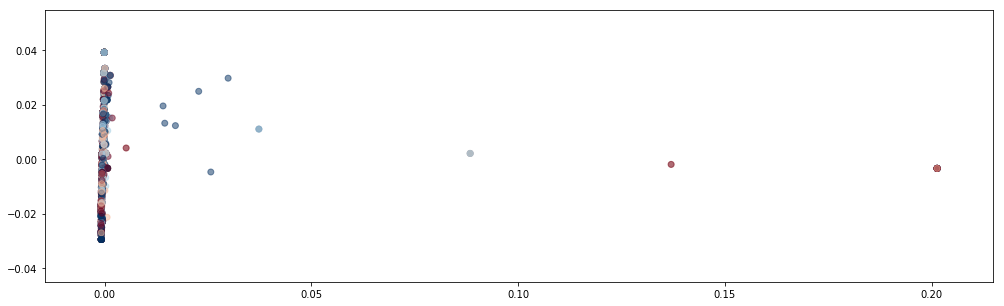

In [122]:
genres = preprocessing.LabelEncoder().fit_transform(df['success'])

x = eigenvectors[:, 1] 
y = eigenvectors[:, 2] 
plt.scatter(x, y, c=genres, cmap='RdBu', alpha=0.5);

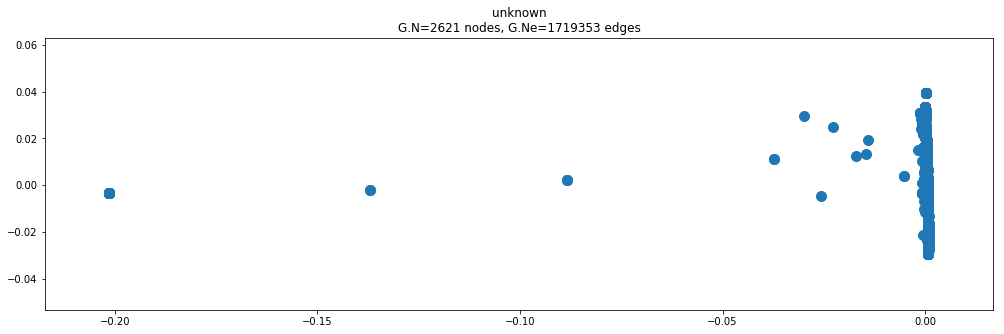

In [123]:
G.set_coordinates(G.U[:, 1:3])
G.plot()

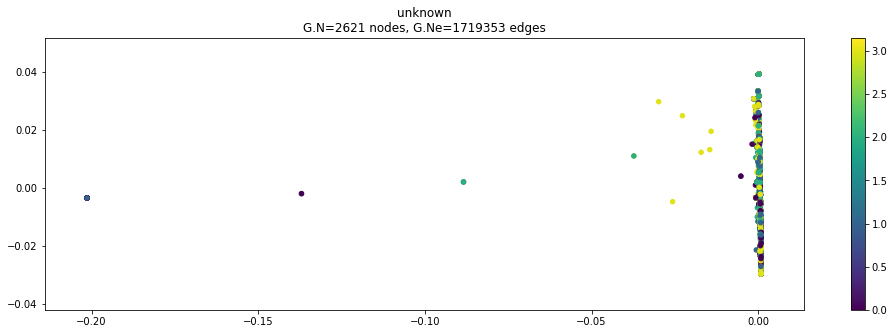

In [124]:
G.plot_signal(genres, vertex_size=20)

### 6. Graph Laplacian and Embedding for gaussian normalization ###

#### 6.1. Sparsification of the graph ###

Keep only a certain number of the weights

In [125]:
NEIGHBORS = 300

#sort the order of the weights
sort_order = np.argsort(Wgauss, axis = 1)

#declaration of a sorted weight matrix
sorted_weights = np.zeros((len(Wgauss), len(Wgauss)))

for i in range (0, len(Wgauss)):  
    for j in range(0, len(Wgauss)):
        if (j >= len(Wgauss) - NEIGHBORS):
            #copy the k strongest edges for each node
            sorted_weights[i, sort_order[i,j]] = Wgauss[i,sort_order[i,j]]
        else:
            #set the other edges to zero
            sorted_weights[i, sort_order[i,j]] = 0

#ensure the matrix is symmetric
bigger = sorted_weights.transpose() > sorted_weights
sorted_weights = sorted_weights - sorted_weights*bigger + sorted_weights.transpose()*bigger

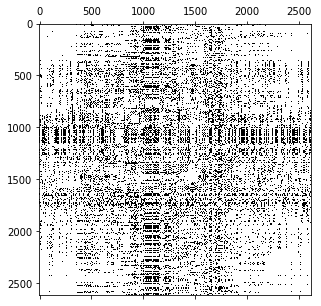

In [126]:
plt.spy(sorted_weights)

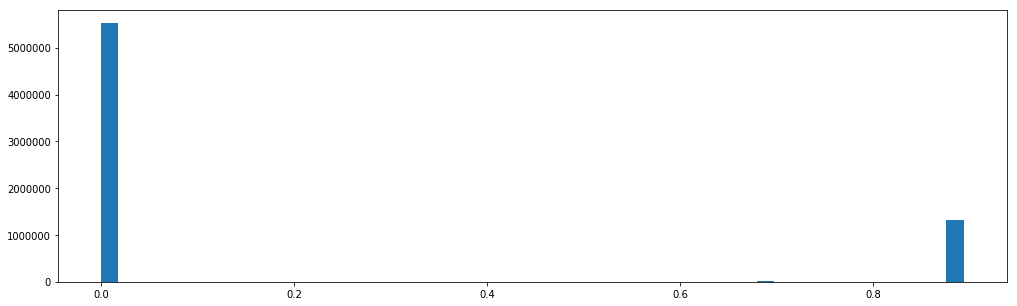

In [127]:
plt.hist(sorted_weights.reshape(-1), bins=50);

#### 6.1. Save the sparsed dataset ####

In [128]:
NormW = pd.DataFrame(sorted_weights)
NormW.head()

,0,1,2,3,4,5,6,7,8,9,...,2611,2612,2613,2614,2615,2616,2617,2618,2619,2620
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.893341,0.0,0.0,0.0,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.893341
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.893341


In [129]:
NormW.to_csv('Saved_Datasets/NormalizedGenreWSparse.csv', index=False)

#### 6.2. Laplacian and graph embedding ####

With pygsp

In [130]:
G = graphs.Graph(sorted_weights)
G.compute_laplacian('normalized')

Other

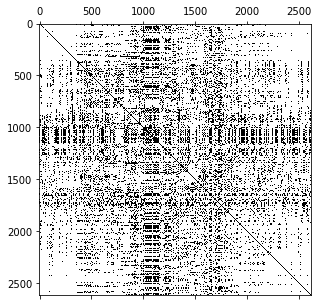

In [131]:
#reminder: L = D - W for weighted graphs
laplacian = np.diag(degrees) - sorted_weights

#computation of the normalized Laplacian
laplacian_norm = scipy.sparse.csgraph.laplacian(sorted_weights, normed = True)

plt.spy(laplacian_norm);

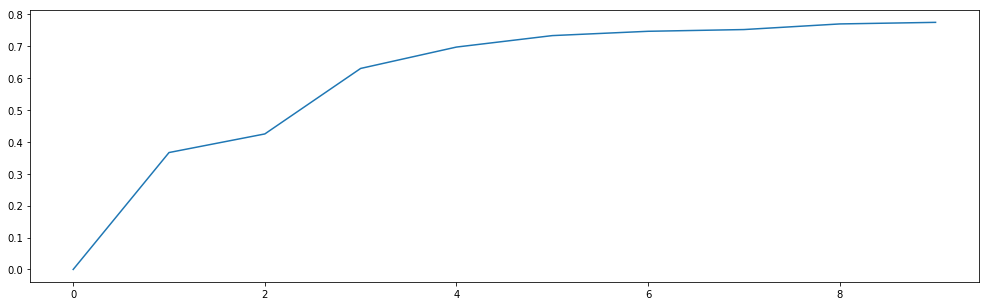

In [132]:
G.compute_fourier_basis(recompute=True)
plt.plot(G.e[0:10]);

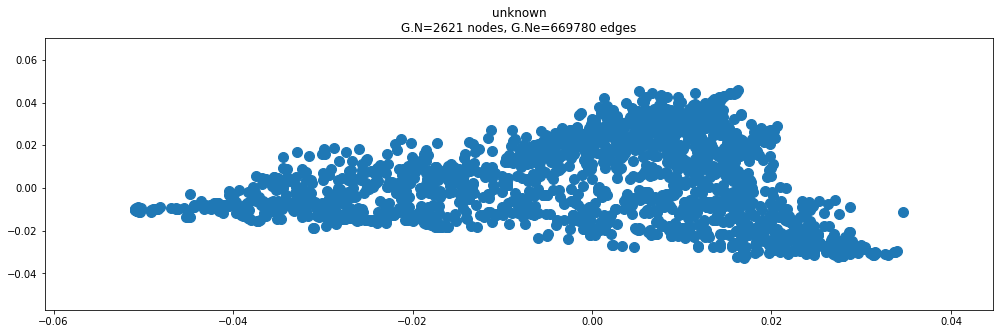

In [133]:
G.set_coordinates(G.U[:, 1:3])
G.plot()

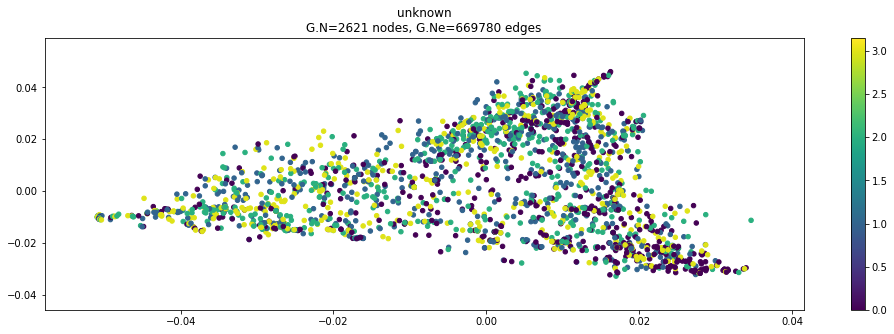

In [134]:
G.plot_signal(genres, vertex_size=20)